In [2]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import shutil, random
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from fastai.vision.all import (
    DataBlock, ImageBlock, CategoryBlock, get_image_files,
    GrandparentSplitter, parent_label, Resize, aug_transforms,
    vision_learner, accuracy, ClassificationInterpretation, resnet34)
from fastai.torch_core import default_device
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
import time

In [3]:
# device selection
def set_device():
    if torch.cuda.is_available(): default_device('cuda'); print('使用CUDA加速')
    elif torch.backends.mps.is_available(): default_device('mps'); print('使用MPS加速')
    else: default_device('cpu'); print('使用CPU')
set_device()

使用MPS加速


In [4]:
def split_dataset(src_base_path, dest_base_path, categories, train_ratio, valid_ratio, test_ratio):
    assert train_ratio + valid_ratio + test_ratio == 1, "Ratios should add up to 1."
    
    # Remove existing destination directory if it exists
    if dest_base_path.exists():
        shutil.rmtree(dest_base_path)
    
    # Create destination directories
    for phase in ['train', 'valid', 'test']:
        for cat in categories:
            os.makedirs(dest_base_path/phase/cat, exist_ok=True)
    
    # Split and copy files for each category
    for cat in categories:
        files = list((Path(src_base_path)/cat).glob('*.*'))
        random.shuffle(files)
        n = len(files)
        
        # Calculate split indices
        train_end = int(n * train_ratio)
        valid_end = train_end + int(n * valid_ratio)
        
        # Split files into three sets
        train_files = files[:train_end]
        valid_files = files[train_end:valid_end]
        test_files = files[valid_end:]
        
        # Copy files to respective directories
        for f in train_files:
            shutil.copy(f, dest_base_path/'train'/cat/f.name)
        for f in valid_files:
            shutil.copy(f, dest_base_path/'valid'/cat/f.name)
        for f in test_files:
            shutil.copy(f, dest_base_path/'test'/cat/f.name)
        
        # Print statistics for each category
        print(f"\nCategory: {cat}")
        print(f"Total files: {n}")
        print(f"Train set: {len(train_files)} files")
        print(f"Valid set: {len(valid_files)} files")
        print(f"Test set: {len(test_files)} files")
        
        # Verify the splits
        assert len(train_files) + len(valid_files) + len(test_files) == n, \
            f"Split verification failed for category {cat}"
    
    # Print overall statistics
    print("\nOverall Dataset Statistics:")
    for phase in ['train', 'valid', 'test']:
        total_files = sum(len(list((dest_base_path/phase/cat).glob('*.*'))) 
                        for cat in categories)
        print(f"{phase.capitalize()} set: {total_files} files")

In [5]:
src_base_path = Path('images-doraemon-walle')
dest_base_path = Path('images')
cats = ['doraemon', 'walle']
split_dataset(src_base_path, dest_base_path, cats, 0.6, 0.2, 0.2)


Category: doraemon
Total files: 160
Train set: 96 files
Valid set: 32 files
Test set: 32 files

Category: walle
Total files: 159
Train set: 95 files
Valid set: 31 files
Test set: 33 files

Overall Dataset Statistics:
Train set: 191 files
Valid set: 63 files
Test set: 65 files


In [6]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)
)
dls = dblock.dataloaders(dest_base_path, bs=64)

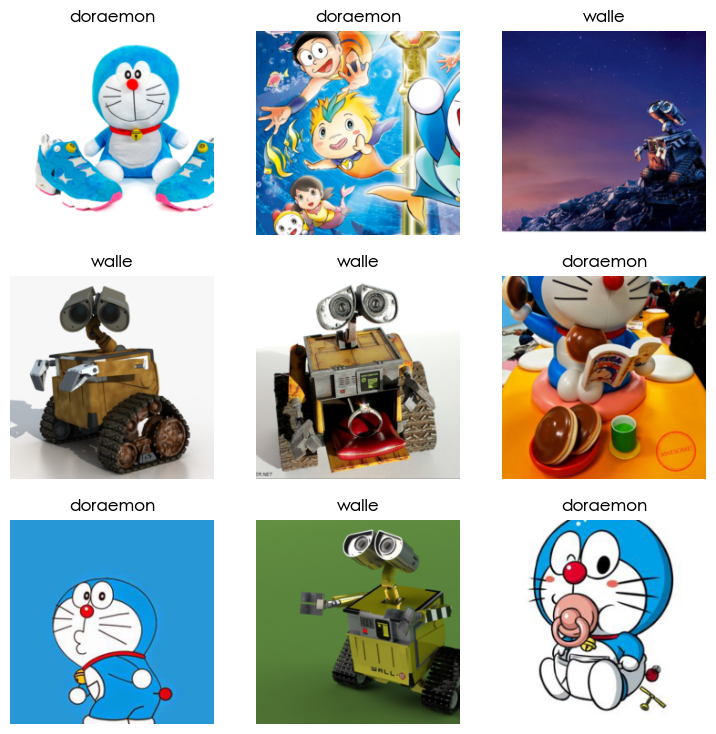

In [7]:
dls.show_batch()

In [8]:
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=5, min_delta=0.01)
save_model_cb = SaveModelCallback(monitor='valid_loss', fname='best_model')

In [9]:
learn = vision_learner(dls, resnet34, metrics=accuracy, cbs=[early_stop_cb, save_model_cb])

In [10]:
learn.fine_tune(100)

epoch,train_loss,valid_loss,accuracy,time
0,1.462713,0.419687,0.746032,00:04


Better model found at epoch 0 with valid_loss value: 0.4196867048740387.


epoch,train_loss,valid_loss,accuracy,time
0,0.448235,0.148178,0.968254,00:03
1,0.412296,0.066032,0.984127,00:03
2,0.321839,0.038393,0.984127,00:03
3,0.264106,0.024022,0.984127,00:03
4,0.222127,0.017206,1.000000,00:03
5,0.187672,0.012890,1.000000,00:03
6,0.167265,0.010043,1.000000,00:03
7,0.150895,0.007570,1.000000,00:03
8,0.134143,0.005845,1.000000,00:03
9,0.118481,0.003989,1.000000,00:03


Better model found at epoch 0 with valid_loss value: 0.1481781005859375.
Better model found at epoch 1 with valid_loss value: 0.06603220105171204.
Better model found at epoch 2 with valid_loss value: 0.03839265555143356.
Better model found at epoch 3 with valid_loss value: 0.024021754041314125.
Better model found at epoch 4 with valid_loss value: 0.017205860465765.
Better model found at epoch 5 with valid_loss value: 0.012890464626252651.
Better model found at epoch 6 with valid_loss value: 0.010042880661785603.
Better model found at epoch 7 with valid_loss value: 0.007569726090878248.
Better model found at epoch 8 with valid_loss value: 0.0058448160998523235.
Better model found at epoch 9 with valid_loss value: 0.003989087417721748.
Better model found at epoch 10 with valid_loss value: 0.003053107066079974.
No improvement since epoch 5: early stopping


In [12]:
test_dl = dls.test_dl(get_image_files(dest_base_path/'test'), with_labels=True)
loss, acc = learn.validate(dl=test_dl)

Better model found at epoch 0 with valid_loss value: 1.0.


In [13]:
loss

0.006937268655747175

In [14]:
acc

1.0

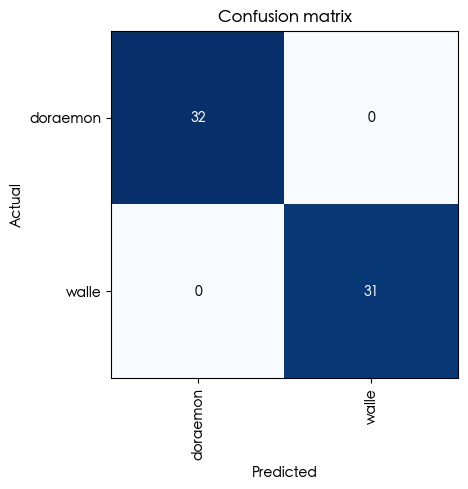

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [17]:
interp.print_classification_report()

              precision    recall  f1-score   support

    doraemon       1.00      1.00      1.00        32
       walle       1.00      1.00      1.00        31

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



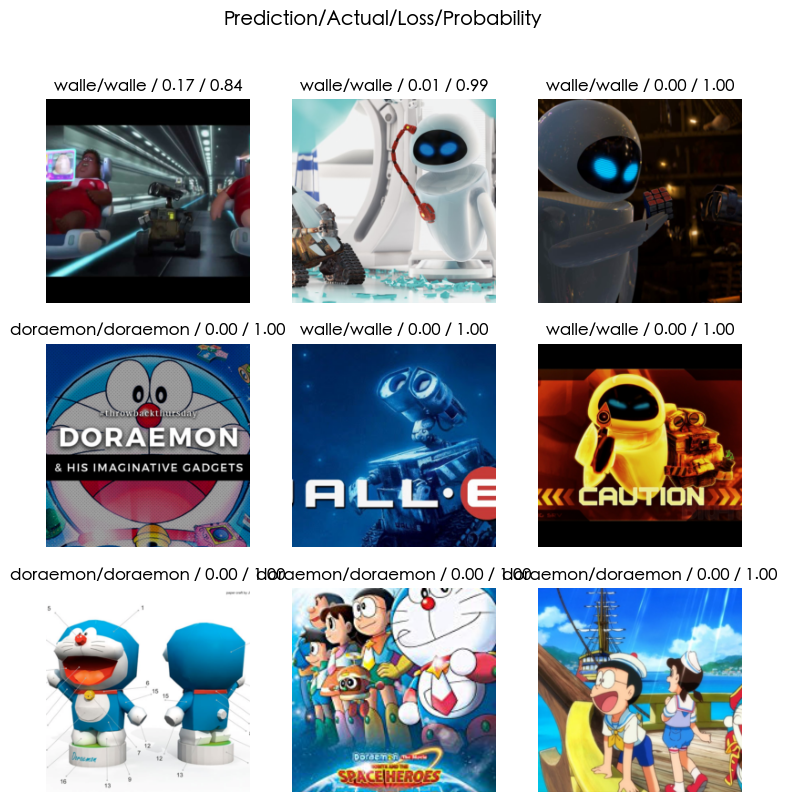

In [18]:
interp.plot_top_losses(9)

In [19]:
learn.export('doraemon_walle_model.pkl')